# Squeezing more info out of fraud data with statistics

Your machine learning models are predicting fraud really well. But are they squeezing all the critical info out of your data? Are they giving you the full picture of what your fraud looks like now? 

Here's an example where machine learning identifies most - but not all - of the features 
with high fraud signals. But some thoughtful statistic analysis uncovers what ML missed. 

## The example
We have generated synthetic data for 10,000 credit card transactions, 0.5% of which are fraudulent. We infused the data with 5 features having strong fraud signals and 50 noise features.  

The 5 fraud-associated features are:
- tx_amount_std (float): standardized transaction amount
- tx_time_of_day_std (float): standardized time of day
- acc_balance_std (float): standardized account balance
- merchant_category: 5 categories
- payment_method: 2 categories

The noise features are Noise1-Noise50.  

The following code generates the data and plots showing how strongly each of the 55 features is associated with fraud.

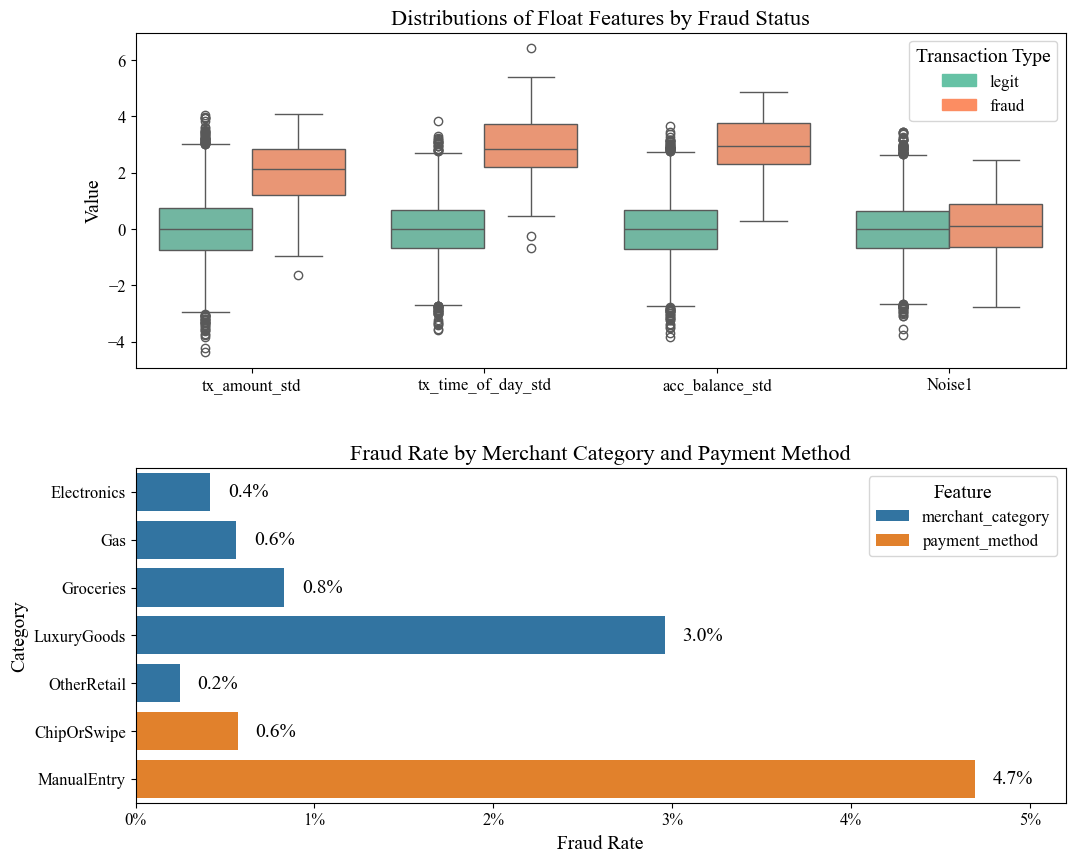

In [1]:

import os, sys, subprocess

def install_packages():
    # Example: list your packages here
    packages = ['numpy', 'pandas', 'matplotlib', 'seaborn', 'scipy', 'xgboost', 'scikit-learn', 'shap']
    for p in packages:
        try:
            __import__(p)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", p])

if 'google.colab' in sys.modules: # Binder installs packages from requirements.txt
    install_packages()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import hypergeom
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap

# Set font depending on environment
if ('BINDER_SERVICE_HOST' in os.environ) or ('google.colab' in sys.modules):
    plt.rcParams['font.family'] = 'DejaVu Serif'
else:
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"]

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

N = 10000
fraud_rate = 0.005
K = int(N * fraud_rate)

def generate_dataset():
    np.random.seed(43)
    y = np.zeros(N, dtype=int)
    fraud_idx = np.random.choice(N, K, replace=False)
    y[fraud_idx] = 1

    merchant_categories = ['Electronics', 'Groceries', 'Gas', 'OtherRetail', 'LuxuryGoods']
    # Equal distribution of merchant categories for simplicity
    merchant_category = np.random.choice(merchant_categories, size=N)

    # Enrich fraud in 'LuxuryGoods'
    luxury_idx = np.where(merchant_category == 'LuxuryGoods')[0]
    desired_fraud_luxury = max(1, int(len(luxury_idx) * 0.03))
    current_fraud_luxury = y[luxury_idx].sum()
    diff = desired_fraud_luxury - current_fraud_luxury
    if diff > 0:
        legit_luxury = luxury_idx[y[luxury_idx] == 0]
        flip = np.random.choice(legit_luxury, min(diff, len(legit_luxury)), replace=False)
        y[flip] = 1
    elif diff < 0:
        fraud_luxury = luxury_idx[y[luxury_idx] == 1]
        flip = np.random.choice(fraud_luxury, min(-diff, len(fraud_luxury)), replace=False)
        y[flip] = 0

    tx_amount_std = np.random.normal(0, 1, N) + 2 * y + np.random.normal(0, 0.5, N)
    payment_method_numeric = np.random.binomial(1, 0.1 + 0.4 * y, N)
    payment_method = np.where(payment_method_numeric == 1, "ManualEntry", "ChipOrSwipe")
    tx_time_of_day_std = np.random.normal(0, 1, N) + 3 * y
    acc_balance_std = np.random.normal(0, 1, N) + 3 * y

    df = pd.DataFrame({
        'merchant_category': merchant_category,
        'tx_amount_std': tx_amount_std,
        'payment_method': payment_method,
        'tx_time_of_day_std': tx_time_of_day_std,
        'acc_balance_std': acc_balance_std,
        'fraud': y
    })

    # Add 50 uncorrelated noise variables using np.random.randn
    for i in range(1, 51):
        df[f'Noise{i}'] = np.random.randn(N)

    return df

def plot_descriptive_statistics(df):
    # Prepare float vars with Noise1 added
    float_vars = ['tx_amount_std', 'tx_time_of_day_std', 'acc_balance_std', 'Noise1']
    
    # Melt dataframe for easy plotting
    df_floats = df.melt(id_vars='fraud', value_vars=float_vars,
                        var_name='feature', value_name='value')
    
    # Create one figure with 4 subplots, vertical layout
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=False)
    
    # Palette and boxplot for floats
    palette = sns.color_palette("Set2", 2)
    sns.boxplot(ax=axes[0], x='feature', y='value', hue='fraud', data=df_floats, palette=palette)
    
    # Custom legend replacing 0/1 with 'legit'/'fraud'
    fraud_patch = mpatches.Patch(color=palette[1], label='fraud')
    legit_patch = mpatches.Patch(color=palette[0], label='legit')
    axes[0].legend(handles=[legit_patch, fraud_patch], title='Transaction Type', loc='upper right')
    axes[0].set_title('Distributions of Float Features by Fraud Status')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Value')
    
    # Prepare data for grouped horizontal barplot
    fraud_rates_mc = df.groupby('merchant_category')['fraud'].mean().reset_index().rename(columns={'merchant_category':'category', 'fraud':'fraud_rate'})
    fraud_rates_mc['feature'] = 'merchant_category'
    
    fraud_rates_pm = df.groupby('payment_method')['fraud'].mean().reset_index().rename(columns={'payment_method':'category', 'fraud':'fraud_rate'})
    fraud_rates_pm['feature'] = 'payment_method'
    
    fraud_rates_combined = pd.concat([fraud_rates_mc, fraud_rates_pm], ignore_index=True)
    
    # Plot horizontal grouped barplot on axes[1]
    sns.barplot(
        y='category',
        x='fraud_rate',
        hue='feature',
        data=fraud_rates_combined,
        ax=axes[1],
        palette=['#1f77b4', '#ff7f0e']  # or Set1 colors, adjust as desired
    )
    
    axes[1].set_xlabel('Fraud Rate')
    axes[1].set_ylabel('Category')
    axes[1].set_title('Fraud Rate by Merchant Category and Payment Method')
    axes[1].set_xlim(0, 0.052)
    axes[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    axes[1].legend(title='Feature', loc='upper right')
    
    # Add labels to bars
    for p in axes[1].patches:
        width = p.get_width()
        if width > 0.001:  
            axes[1].text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.1%}', va='center')
    
    plt.subplots_adjust(hspace=0.3)
    plt.show()

df = generate_dataset()
plot_descriptive_statistics(df)

## Fraud signals
The above plots show that the 5 non-noise features 
- tx_amount_std
- tx_time_of_day_std
- acc_balance_std
- merchant_category
- payment_method

are strongly associated with fraud, and the noise features aren't. (I just plotted Noise1, so as not to bore you.)

## The ML model
We're not going to get fancy with the modeling in this illustration. We'll use a simple XGBoost model to illustrate our point.  

The following code fits the model and calculates feature importance through Gain, SHAP, and Permutation importance. We'll use it to see which features the ML model considers to be most important for predicting fraud.


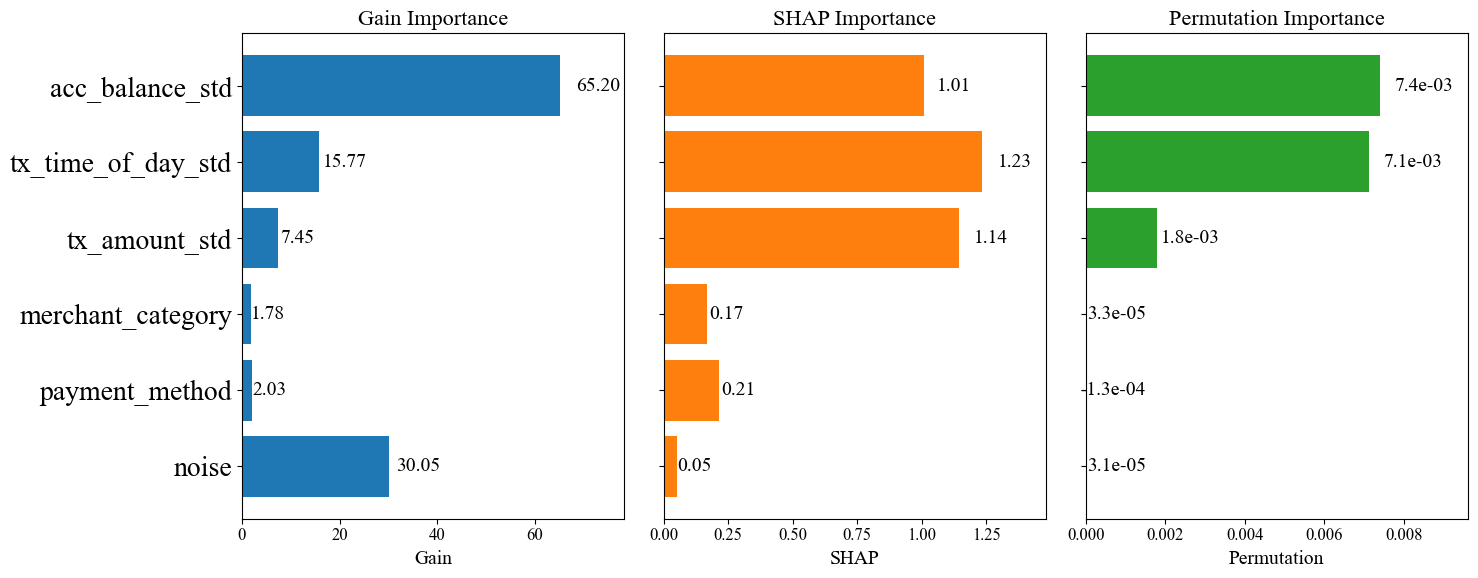

In [2]:

def train_and_get_importances(df):
    feature_cols = ['merchant_category', 'tx_amount_std', 'payment_method',
                    'tx_time_of_day_std', 'acc_balance_std'] + [f'Noise{i}' for i in range(1, 51)]
    X = pd.get_dummies(df[feature_cols], drop_first=True)
    y = df['fraud']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    model = xgb.XGBClassifier(eval_metric='logloss', n_estimators=50)
    model.fit(X_train, y_train)

    fi = model.get_booster().get_score(importance_type='gain')

    X_test = X_test[X_train.columns]
    dmatrix = xgb.DMatrix(X_test.values, feature_names=X_test.columns.to_list())
    shap_values = model.get_booster().predict(dmatrix, pred_contribs=True)[:, :-1]

    perm_imp = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)

    col_idx_map = {c: i for i, c in enumerate(X.columns)}

    def feature_group_columns(prefixes):
        return [c for c in X.columns if any(c.startswith(p) for p in prefixes)]

    mc_cols = feature_group_columns(['merchant_category_'])
    tx_amount_cols = feature_group_columns(['tx_amount_std'])
    payment_method_cols = feature_group_columns(['payment_method_'])
    tx_time_cols = feature_group_columns(['tx_time_of_day_std'])
    acc_balance_cols = feature_group_columns(['acc_balance_std'])
    noise_cols = feature_group_columns(['Noise'])

    def calc_metrics(cols):
        gain = sum(fi.get(c, 0) for c in cols)
        shap_val = np.mean(np.abs(shap_values[:, [col_idx_map[c] for c in cols]])) if cols else 0
        perm_val = np.mean(perm_imp.importances_mean[[col_idx_map[c] for c in cols]]) if cols else 0
        return gain, shap_val, perm_val

    groups_metrics = {
        'acc_balance_std': calc_metrics(acc_balance_cols),
        'tx_time_of_day_std': calc_metrics(tx_time_cols),
        'tx_amount_std': calc_metrics(tx_amount_cols),
        'merchant_category': calc_metrics(mc_cols),
        'payment_method': calc_metrics(payment_method_cols),
        'noise': calc_metrics(noise_cols)
    }
    return groups_metrics

def plot_importance_comparison(metrics):
    # Reverse features list first
    features = list(metrics.keys())[::-1]

    # Extract values corresponding to reversed features
    gain_vals = [metrics[f][0] for f in features]
    shap_vals = [metrics[f][1] for f in features]
    perm_vals = [metrics[f][2] for f in features]

    fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
    for ax in axes:
        ax.tick_params(axis='y', labelsize=20)
        
    # Add labels, with scientific notation for permutation
    def add_labels(ax, values, scientific=False):
        for i, v in enumerate(values):
            label = f'{v:.2f}' if not scientific else f'{v:.1e}'
            ax.text(v * 1.05, i, label, va='center', fontsize=14, color='black')

    axes[0].barh(features, gain_vals, color='tab:blue')
    axes[0].set_xlabel('Gain')
    axes[0].set_title('Gain Importance')
    axes[0].set_xlim(0, max(gain_vals) * 1.2)
    add_labels(axes[0], gain_vals)

    axes[1].barh(features, shap_vals, color='tab:orange')
    axes[1].set_xlabel('SHAP')
    axes[1].set_title('SHAP Importance')
    axes[1].set_xlim(0, max(shap_vals) * 1.2)
    add_labels(axes[1], shap_vals)

    axes[2].barh(features, perm_vals, color='tab:green')
    axes[2].set_xlabel('Permutation')
    axes[2].set_title('Permutation Importance')
    axes[2].set_xlim(0, max(perm_vals) * 1.3)
    add_labels(axes[2], perm_vals, scientific=True)

    plt.tight_layout()
    plt.show()

imp = train_and_get_importances(df)
plot_importance_comparison(imp)


## Which features does the ML model think are the most important?
Regardless of the metric used (Gain, SHAP, or Permutation Importance), the model pretty much considers these features to be most important for predicting fraud:
- acc_balance_std,
- tx_time_of_day_std, and
- tx_amount_std.

These pretty much have the longest bars in the above chart, regardless of color. I say "pretty much" because oddly enough, Gain also considers noise to be very important. 

## Which important features did the ML model miss?
All metrics consider the remaining two features to be markedly less important for predicting fraud. They are:
- merchant_category and
- payment_method.

Each has markedly shorter bars than the prior three features (acc_balance_std, tx_time_of_day_std, and tx_amount_std) do. Setting aside the odd noise Gain, these two features seem more comparable to noise than to the three important features. 

But this seems odd - our previous bar charts showed these features to have strong associations with fraud. Fraud is disproportionately involved in the purchases of luxury goods and with payment manual entry. 

## Why did the ML model miss them?
Why didn't XGBoost think merchant_category and payment_method were very important for predicting fraud? Why did it say they were more comparable to noise, despite their strong fraud signals?

There could be various reasons. First, I might have chosen a bad model. It's entirely possible that a carefully tuned XGBoost model, or another type of ML model entirely, might identify merchant_category and payment_method as crucial for predicting fraud. 

But one thing about ML models is that they are designed to be parsimonious, through regularization. This is generally a good thing, since we don't want to overfit the data. But it also means that if a model can predict well without some features - even ones with high fraud signals - it won't regard them as important. If the model predicts well with features $X_1$ and $X_2$, with only marginal improvements from adding $X_3$, it won't see $X_3$ as important, even if $X_3$ is strongly associated with fraud. 

## So what can we do? 
Feature importance plots don't come with a guarantee that they are providing all the high fraud signals. If you're trying to understand/prevent fraud and/or identify new ways that criminals are stealing, I'm guessing you want to know about all clues that are important to solving the puzzle. Fortunately, statistical analysis can help

The following code looks for aberrant signals by considering consistency with chance variation.  How likely is it that we would see fraud patterns as extreme as we see in the data, simply by chance? 

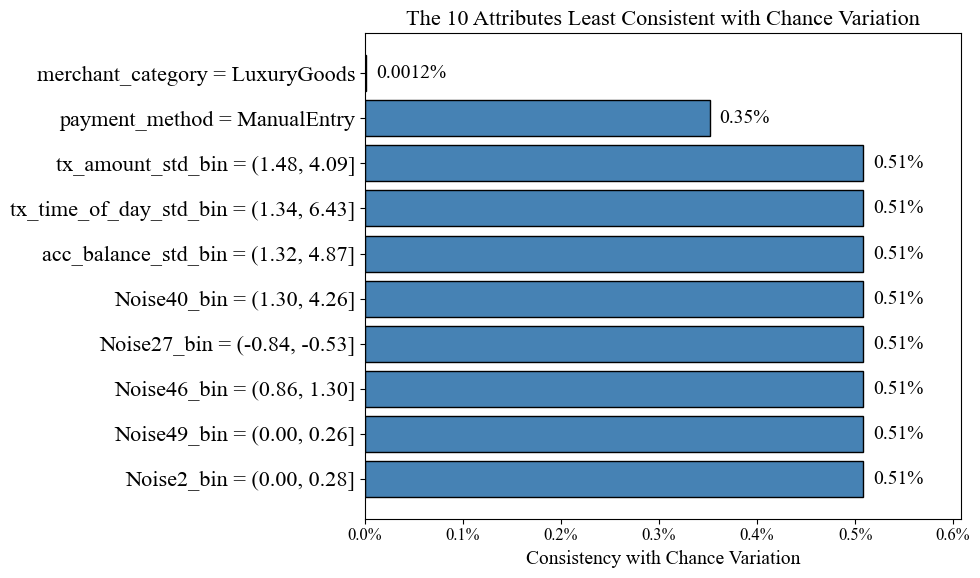

In [3]:


def format_bin_label(label):
    if isinstance(label, pd.Interval):
        return f"({label.left:.2f}, {label.right:.2f}]"
    return str(label)

float_vars = [f'Noise{i}' for i in range(1, 51)] + ['tx_amount_std', 'tx_time_of_day_std', 'acc_balance_std']

for v in float_vars:
    df[v + '_bin'] = pd.qcut(df[v], q=10, duplicates='drop')
    df[v + '_bin'] = df[v + '_bin'].cat.rename_categories(format_bin_label)

cat_vars = ['merchant_category', 'payment_method']
binned_float_vars = [f"{v}_bin" for v in float_vars]
attr_vars = cat_vars + binned_float_vars

results = []
for var in attr_vars:
    grouped = df.groupby(var, observed=False)['fraud'].agg(['sum', 'count']).reset_index()
    if var.endswith('_bin'):
        grouped[var] = grouped[var].apply(format_bin_label)
    grouped['var'] = var
    grouped['attr'] = grouped[var].astype(str)
    grouped['consistency'] = grouped.apply(lambda x: consistency_w_chance(x['sum'], x['count'], K, N), axis=1)
    results.append(grouped[['var', 'attr', 'sum', 'count', 'consistency']])

results_df = pd.concat(results, ignore_index=True)
least_consistent_attrs_df = results_df.nsmallest(10, 'consistency').copy()
least_consistent_attrs_df['var_attr'] = least_consistent_attrs_df['var'] + " = " + least_consistent_attrs_df['attr']

fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(least_consistent_attrs_df))
bars = ax.barh(y_pos, least_consistent_attrs_df['consistency'], color='steelblue', edgecolor='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(least_consistent_attrs_df['var_attr'], fontsize=16)
ax.invert_yaxis()

ax.set_xlabel("Consistency with Chance Variation")
ax.set_title("The 10 Attributes Least Consistent with Chance Variation")
ax.set_xlim(0, least_consistent_attrs_df['consistency'].max() + 0.001)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=1))

for i, bar in enumerate(bars):
    width = bar.get_width()
    label = f"{width:.4%}" if least_consistent_attrs_df.iloc[i]['var'].startswith('merchant') else f"{width:.2%}"
    ax.text(width + 0.0001, bar.get_y() + bar.get_height() / 2,
            label, va='center', ha='left', color='black')

plt.tight_layout()
plt.show()

The above plot depicts the 10 feature attributes whose fraud signals are least consistent with chance variation.  And lo and behold, the two fraud signals that XGBoost missed (luxury goods and manual payment entry) are right on top. 

# Summary

Your ML models can perform really well and still fail to give you critical information for identifying fraud patterns. Feature importance plots don't come with a guarantee that they are providing all the strong fraud signals in your data. Statistical anomaly detection can provide you with critical clues that your ML models don't.

The statistical calculation I did here is one way to detect anomalies, but there are many more. Will statistics always give the info you need? Of course not. Will it give you some false flags? Yes, it will. (Witness the noise in the top 10 in this chart.) Will the best ML model identify all strong fraud signals? I'm thinking No: Regularization is an ML hero but s/he comes at a price.  

In fraud prevention, every clue is potentially critical. Is your ML model giving you the fraud signal you need to identify the threat hidden in your data? Statistical anomaly detection might provide the clues you're missing. 
